# Matching float profiles to satellite pixels
## Import Packages

In [1]:
import pandas as pd
import xarray as xr
import glob
from pyhdf.SD import SD,SDC
import numpy as np
from datetime import *
from FromBieito.soccom_functions import *
from FromBieito.Calc_Chl import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

### Functions

In [13]:
from PyAstronomy import pyasl

In [14]:
# calculate the vertically integrated data column inventory using the composite trapezoidal rule
def integrate(zi, data, depth_range):
    n_profs = len(data)
    zi_start = abs(zi - depth_range[0]).argmin() # find location of start depth
    zi_end =  abs(zi - depth_range[1]).argmin() # find location of end depth
    zi_struct = np.ones((n_profs, 1)) * zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[:, zi_start : zi_end] # add +1 to get the 200m value
    col_inv = []
    for n in range(0, len(data)):
        col_inv.append(np.trapz(data[n,:][~np.isnan(data[n,:])], zi_struct[n,:][~np.isnan(data[n,:])]))
    return col_inv

In [15]:
# calculate the vertically integrated data column inventory using the composite trapezoidal rule
def integrate_wMLD(zi, data, start_depth, MLD):
    #n_profs = len(data)
    zi_start = abs(zi - start_depth).argmin() # find index of start depth
    zi_end =  abs(zi - MLD).argmin() # find index of end depth
    zi_struct = zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[zi_start : zi_end] # add +1 to get the 200m value
    col_inv = []
    #for n in range(0, len(data)):
    col_inv.append(np.trapz(data[:][~np.isnan(data[:])], zi_struct[:][~np.isnan(data[:])]))
    return col_inv

In [16]:
def integrate_chl(data):
    # Interpolate/get data set up
    zi = np.arange(0, 2005, 5) # 5 = 400 depth intervals between 0m to 2000m
    #or zi=self.gr["depth"] #which = np.arange(0,2000+dz,dz)
    chl_int = FLOAT.gr["Chl_a"] # interpolated chl values across zi depth intervals for all profiles
    
    ### Using a fixed lower limit
    # Integrate chl - total chl in upper 200m
    upperlim=0
    lowerlim=200
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 
    
    ### Using the deepest MLD seen by the float
    # Integrate chl - total chl in upper ML - to deepest MLD seen by float
    upperlim=0
    lowerlim=np.nanmax(FLOAT.gr["mld"])
    print(FLOAT.gr["WMO_code"],"Deepest mixed layer: %1.0f m"%(lowerlim))
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 

    ### Using the profile specific MLD
    H2=FLOAT.gr["mld"]
    nz= len(H2)
    # using MLD calculated for each individual profile
    chl_T=chl_int.T # the interpolated chl from FLOAT.gr
    AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'] = np.full( nz, np.nan )
    for i in range(nz): #nz = length H2 (mld array) = number of profiles
        if np.isnan(H2[i]):
            AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'][i] = np.nan # in float used to write code, there were some nan for MLD because of no salinity values recorded
        else:
            lowerlim=H2[i]
            data=chl_T[i,:]
            AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'][i] = np.array(integrate_wMLD(zi, data, upperlim, lowerlim)) # integrate interpolated nitrate values between 0m-specificMLD
    
    ### The entire water column
    upperlim=0
    lowerlim=2000
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 
    
    return AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'],AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC']
    #or return AllFloats                                      

In [17]:
def chl_underornoice(data,yix):
    H2=FLOAT.gr["mld"]
    nz= len(H2)
    ## How much of the annual chl was present under ice?
    AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno']=np.full(nz, np.nan)
    for i in range(nz):
        test=np.isnan(FLOAT.gr["Temperature"][0,i]) & np.isnan(FLOAT.gr["Temperature"][1,i]) & np.isnan(FLOAT.gr["Temperature"][2,i]) #& np.isnan(FLOAT.gr["Chl_a"][3,i]) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
        temp_thres=np.nanmedian(FLOAT.gr["Temperature"][0:4,i])<(-1.78)
        if test.all() | temp_thres.all():
            AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]=1
        else:
            AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]=0
    #### Over the whole float timeseries
    ui=np.where(np.isnan(FLOAT.gr["Chl_a"][0,:]) & np.isnan(FLOAT.gr["Chl_a"][1,:]) & np.isnan(FLOAT.gr["Chl_a"][2,:]) & np.isnan(FLOAT.gr["Chl_a"][3,:])) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
    ui_tot=np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'][ui])
    nui=np.where(np.isfinite(FLOAT.gr["Chl_a"][0,:]) & np.isnan(FLOAT.gr["Chl_a"][1,:]) & np.isnan(FLOAT.gr["Chl_a"][2,:]) & np.isnan(FLOAT.gr["Chl_a"][3,:])) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
    nui_tot=np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'][test])
    #print(np.nansum(chl_intr_dMLD))
    #print('approx % of chl under ice during float timeseries:', round(ui_tot/nui_tot*100,2),'%')
    
    #### get index for profiles that are in austral year, under ice and ice free
    AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=[]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=[]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=[]
    for i in range(len(FLOAT.gr["date_dt"])):
        decy = pyasl.decimalYear(FLOAT.gr["date_dt"][i]) #might be more efficient to make decy an np.int_ here so all the logical queries can be called at once?...
        smol=decy>=(yix-0.5)
        tol=decy<(yix+0.5)
        underice=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]>0
        icefree=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]==0
        if smol==tol:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"],np.int_(i))
        if smol==tol==underice:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"],i)
        if smol==tol==icefree:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"],i)
    AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"])
    AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"])
    AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"])
    # pos exlude years with <34 profiles from next lot of calculations?
    ### Calculate how much Chl is present at specific times - whole year, under ice, when there's no ice
    #could add if rule: if len(AllFloats['5904472'][endyear]["aust_ix"])<34: continue... or [] =np.nan
    #### Total in austral year
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]]),6)
    #### Total under ice
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]]),6)
    #### Total when ice-free
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]]),6)
    #### proportion under ice for austral year
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_icefree"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
    #### Mean [Chl] in WC
    #AllFloats['5904472'][yix]["Mean_aus_chl"]=np.round(np.nanmean(chl_intrWC[AllFloats['5904472'][yix]["aust_ix"]]),6)
    #for yix in range(startyear,endyear+1,1):
    print(yix,"under ice",np.round(AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"],3))
    #for yix in range(startyear,endyear+1,1):
    #    print(yix,"ice free",np.round(AllFloats['5904472'][yix]["Prop_icefree"],3))
    
    #return AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'],AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_icefree"]
    return AllFloats

In [18]:
def nosat_chl(data,yix):
    ## What is happening to the chl when the satellite isn't seeing the ice-free waters (from ~mid March)?
    Mar3015=datetime.datetime(2015,3,30)
    decmar15=pyasl.decimalYear(Mar3015)
    Mar2116=datetime.datetime(2016,3,21)
    decmar16=pyasl.decimalYear(Mar2116)
    Mar2217=datetime.datetime(2017,3,22)
    decmar17=pyasl.decimalYear(Mar2217)
    Mar1418=datetime.datetime(2018,3,14)
    decmar18=pyasl.decimalYear(Mar1418)
    Mar1419=datetime.datetime(2019,3,14)
    decmar19=pyasl.decimalYear(Mar1419)
    Mar2120=datetime.datetime(2020,3,21)
    decmar20=pyasl.decimalYear(Mar2120)

    AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=[]
    for i in range(len(FLOAT.gr["date_dt"])):
        decy = pyasl.decimalYear(FLOAT.gr["date_dt"][i])
        smol=decy>=(yix-0.5)
        tol=decy<(yix+0.5)
        icefree=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]==0
        if yix==2015:
            mar=decy>=decmar15
        elif yix==2016:
            mar=decy>decmar16
        elif yix==2017:
            mar=decy>decmar17
        elif yix==2018:
            mar=decy>decmar18
        elif yix==2019:
            mar=decy>decmar19
        elif yix==2020:
            mar=decy>decmar20
        elif yix==2021:
            continue
        if smol==tol==mar: #==icefree
            AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"],i)
        AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"])
    
    #could add if rule: if len(AllFloats['5904472'][endyear]["aust_ix"])<34: continue... or [] =np.nan
    #### Total chl when satellite field of view reduces during March, but before ice returns
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_nosat_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]]),6)
    #### proportion under ice for austral year
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_nosat"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_nosat_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
    print(yix,"no satellite coverage",np.round(AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_nosat"],3))
    return AllFloats

## Load in satellite data

In [22]:
rootdir = '../data/interim/'
satfiles = sorted(glob.glob(rootdir+"/*.nc"))
print(satfiles)

fd=xr.open_dataset(satfiles[0])
#display(fd)

['../data/interim\\npp_2014onwards.nc']


### Time is in matlab datenum 
= Need to convert to datetime

* Pos ask about how to put the values into the xarray dataset, but for now, is made as a separate variable (means a few extra lines later on)

In [3]:
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return datetime.datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)

In [4]:
nz= len(fd.date.values)
datezz=[]
for i in range(0,nz):
    datezz=np.append(datezz,datenum_to_datetime(fd.date.values[i]))
print(datezz[0])

2014-01-04 23:59:59.500003


In [21]:
#test isel command
#display(fd['npp'].isel(date=6,lat=500,lon=800))
fd['npp'].isel(date=6,lat=500,lon=800).values

array(497.19674683)

## Load in float data
One at a time for the moment

In [29]:
file_folder = "../data/raw/WGfloats/" # specify directory relative to location of notebook #SOCCOM_HiResQC_LIAR_21Dec2021_netcdf # WGfloats
###    For single float: 
#float_number = "5904471" #7900918 #9094/5904471 #5904397
#files = sorted(glob.glob(file_folder+"/*"+float_number+"*.nc"))
#print(files)
#uses the function that reads and grids the data
#FLOAT = grids_one_buoy(files[0],display_info = False, DO_ml_crit = 2.5, clear_short = True)
#print("This float is WMO code: %s"%(FLOAT.gr["WMO_code"]))

###    For all floats:
files = sorted(glob.glob(file_folder+"/*.nc"))
print(files)

['../data/raw/WGfloats\\5904397_HRQC.nc', '../data/raw/WGfloats\\5904467_HRQC.nc', '../data/raw/WGfloats\\5904468_HRQC.nc', '../data/raw/WGfloats\\5904471_HRQC.nc', '../data/raw/WGfloats\\5904472_HRQC.nc', '../data/raw/WGfloats\\5905991_HRQC.nc', '../data/raw/WGfloats\\5905992_HRQC.nc', '../data/raw/WGfloats\\5905993_HRQC.nc', '../data/raw/WGfloats\\5905994_HRQC.nc', '../data/raw/WGfloats\\5905995_HRQC.nc', '../data/raw/WGfloats\\5906033_HRQC.nc', '../data/raw/WGfloats\\5906034_HRQC.nc']


### Calculate depth integrated chl to compare to satellite NPP

In [30]:
import warnings
warnings.filterwarnings('ignore')
# because next cell has warnings for each iteration -- ask someone about them in future

5904397 Deepest mixed layer: 142 m
2015 under ice 0.027
2015 no satellite coverage 0.208
2016 under ice 0.161
2016 no satellite coverage 0.289
2017 under ice 0.102
2017 no satellite coverage 0.272
2018 under ice 0.1
2018 no satellite coverage 0.284
2019 under ice 0.153
2019 no satellite coverage 0.293
2020 under ice 0.158
2020 no satellite coverage 0.0


array([831.43713379, 708.97998047, 330.08935547, 444.5123291 ,
       374.69992065, 287.65148926, 230.36619568, 207.56211853,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan, 632.99822998,
       564.17169189, 551.52044678, 282.78890991, 301.66842651,
       221.18663025, 248.36575317, 223.1076355 , 164.2321167 ,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,       

5904467 Deepest mixed layer: 141 m
2014 under ice nan
2014 no satellite coverage nan
2015 under ice 0.022
2015 no satellite coverage 0.127
2016 under ice 0.117
2016 no satellite coverage 0.138
2017 under ice 0.123
2017 no satellite coverage 0.203
2018 under ice 0.115
2018 no satellite coverage 0.309
2019 under ice 0.121
2019 no satellite coverage 0.207


array([         nan,          nan,          nan,          nan,
       666.47772217, 513.41552734, 422.82580566, 480.77587891,
       404.8036499 , 294.80941772, 244.24226379, 196.13264465,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan, 756.9107666 ,
       608.83251953, 626.57861328, 422.23019409, 372.36685181,
       309.06692505, 189.82902527, 196.11036682,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,       

5904468 Deepest mixed layer: 178 m
2015 under ice 0.026
2015 no satellite coverage 0.12
2016 under ice 0.047
2016 no satellite coverage 0.113
2017 under ice 0.08
2017 no satellite coverage 0.212
2018 under ice 0.068
2018 no satellite coverage 0.299
2019 under ice 0.049
2019 no satellite coverage 0.253
2020 under ice 0.049
2020 no satellite coverage 0.085


array([          nan,  774.98156738,  587.36126709,  520.63458252,
        388.37121582,  315.39306641,  243.00469971,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,  701.12579346,  887.47937012,
        756.75964355,  636.23474121,  573.06445312,  531.74438477,
        203.67282104,  223.75296021,  216.53466797,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           

5904471 Deepest mixed layer: 209 m
2014 under ice nan
2014 no satellite coverage nan
2015 under ice 0.051
2015 no satellite coverage 0.134
2016 under ice 0.056
2016 no satellite coverage 0.123
2017 under ice 0.07
2017 no satellite coverage 0.174
2018 under ice 0.051
2018 no satellite coverage 0.21
2019 under ice 0.062
2019 no satellite coverage 0.082


array([         nan,          nan,          nan,          nan,
       690.24206543, 540.31512451, 371.45809937, 374.76550293,
       313.2336731 , 178.59417725,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan, 982.40441895, 777.51879883,
       848.88690186, 629.41229248, 346.51107788, 245.07223511,
       217.56832886,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,       

5904472 Deepest mixed layer: 145 m
2015 under ice 0.172
2015 no satellite coverage 0.246
2016 under ice 0.174
2016 no satellite coverage 0.183
2017 under ice 0.047
2017 no satellite coverage 0.037
2018 under ice 0.128
2018 no satellite coverage 0.231
2019 under ice 0.126
2019 no satellite coverage 0.291


array([          nan,           nan,  493.63708496,  296.78533936,
        302.7484436 ,  312.66674805,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,  460.57571411,  528.53527832,  529.31567383,
        509.98596191,  571.29107666,  395.09716797,  444.53543091,
        313.86590576,  315.49353027,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           

5905991 Deepest mixed layer: 135 m
2019 under ice 0.191
2019 no satellite coverage 0.605
2020 under ice 0.132
2020 no satellite coverage 0.191
2021 under ice 0.049
2021 no satellite coverage 0.0


array([         nan,          nan, 378.12689209, 324.17205811,
       269.49633789, 304.91973877, 223.62831116,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan, 297.54879761, 338.26513672, 347.84963989,
       326.73153687, 296.20077515, 300.03125   , 256.68695068,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,       

5905992 Deepest mixed layer: 188 m
2019 under ice 0.027
2019 no satellite coverage 0.244
2020 under ice 0.105
2020 no satellite coverage 0.121
2021 under ice 0.071
2021 no satellite coverage 0.0


array([543.31695557, 522.39031982, 385.36083984, 347.15673828,
       277.50445557, 308.03939819, 212.06367493,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan, 678.66015625,
       644.57391357, 665.87408447, 494.07046509, 402.94265747,
       253.57141113, 285.80487061, 310.47296143,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,       

5905993 Deepest mixed layer: 530 m
2019 under ice 0.025
2019 no satellite coverage 0.065
2020 under ice 0.504
2020 no satellite coverage 0.0


array([809.45977783,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan])

5905994 Deepest mixed layer: 176 m
2019 under ice 0.152
2019 no satellite coverage 0.506
2020 under ice 0.051
2020 no satellite coverage 0.052
2021 under ice 0.037
2021 no satellite coverage 0.0


array([          nan,  562.42205811,  421.11087036,  284.72091675,
        356.85046387,  253.98968506,  220.50489807,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan, 1208.4954834 ,
       1201.40759277, 1415.95568848,   89.65307617,  635.84899902,
        544.69342041,  645.55279541,  609.04821777,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           

5905995 Deepest mixed layer: 139 m
2019 under ice 0.02
2019 no satellite coverage 0.224
2020 under ice 0.145
2020 no satellite coverage 0.154
2021 under ice 0.099
2021 no satellite coverage 0.0


array([860.74987793, 597.64111328, 627.69726562, 528.25720215,
       458.7828064 , 350.06494141, 307.51565552, 306.08859253,
       318.94058228,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
       442.40234375, 650.77709961, 449.59631348, 675.61700439,
       448.75158691, 497.72955322, 446.1000061 , 411.85351562,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,       

5906033 Deepest mixed layer: 129 m
2019 under ice 0.252
2019 no satellite coverage 1.0
2020 under ice 0.059
2020 no satellite coverage 0.055
2021 under ice 0.169
2021 no satellite coverage 0.0


array([          nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan, 1032.0222168 ,  935.80841064,
        917.23547363,  759.03509521,  672.05010986,  702.71038818,
        306.4125061 ,  279.10360718,  269.32192993,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           

5906034 Deepest mixed layer: 115 m
2019 under ice 0.0
2019 no satellite coverage 1.0
2020 under ice 0.111
2020 no satellite coverage 0.185
2021 under ice 0.142
2021 no satellite coverage 0.0


array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan, 698.38726807, 637.20800781,
       671.26849365, 555.59954834, 597.48394775, 581.44146729,
       426.77041626, 395.9894104 , 250.85299683,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
       327.46011353, 417.14987183,          nan, 484.69

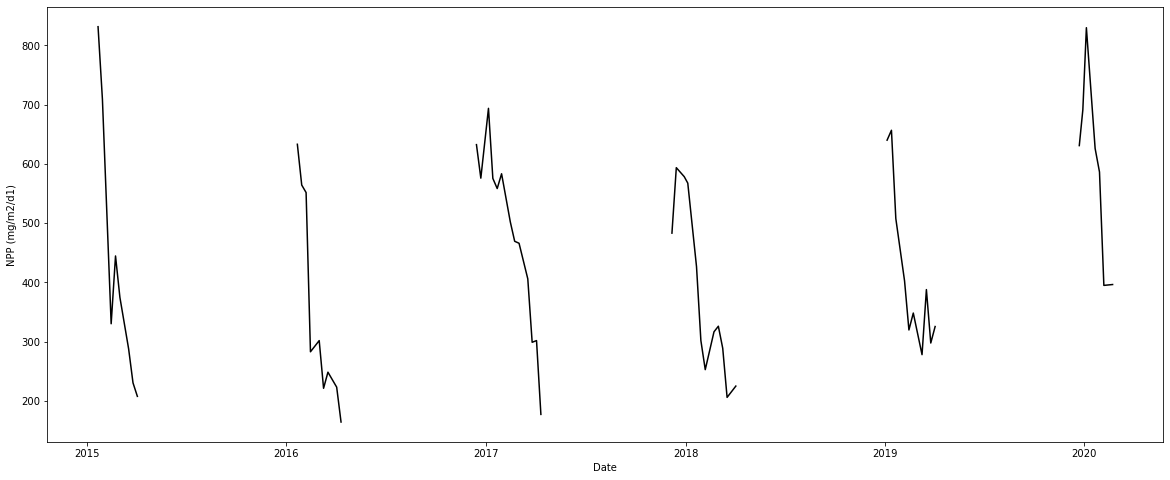

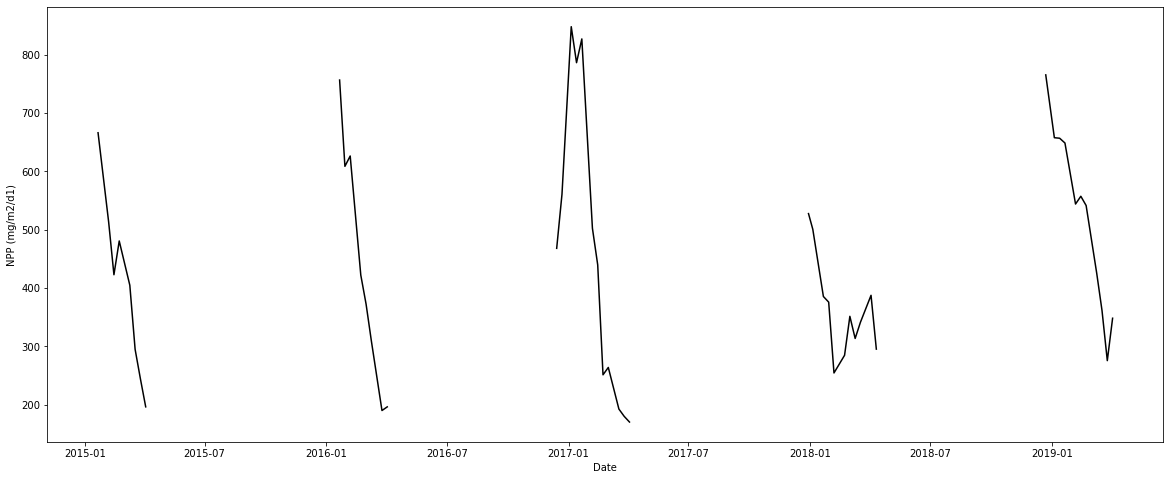

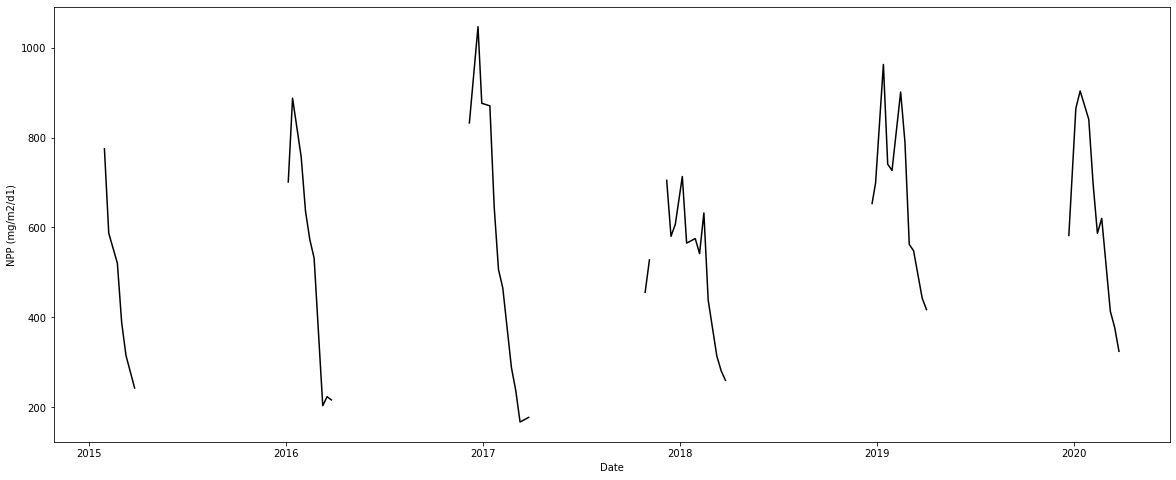

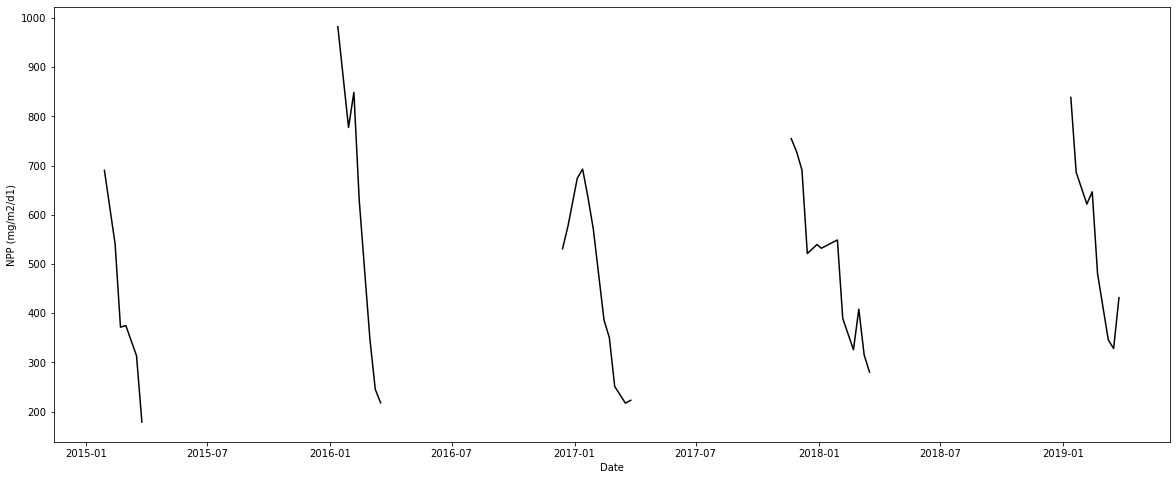

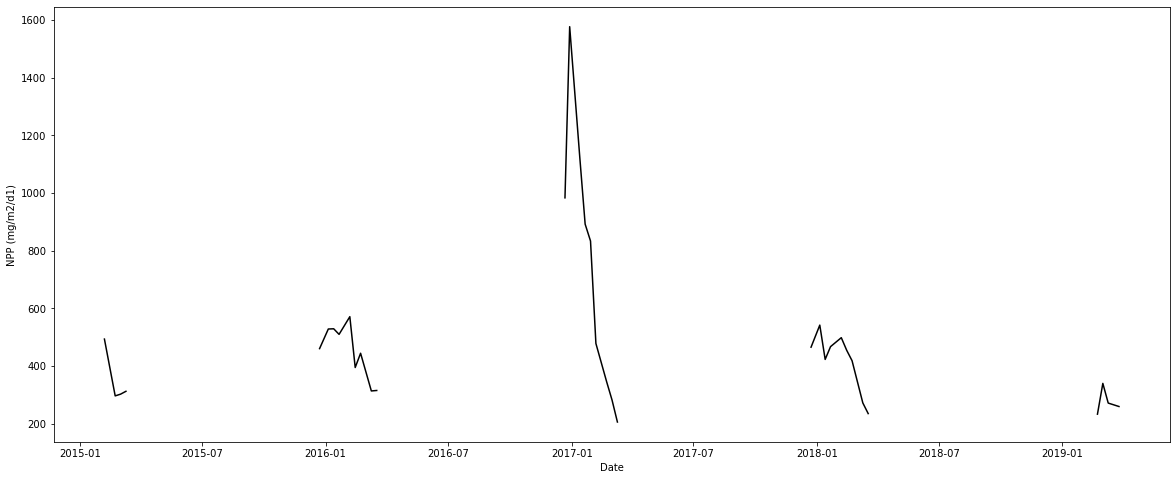

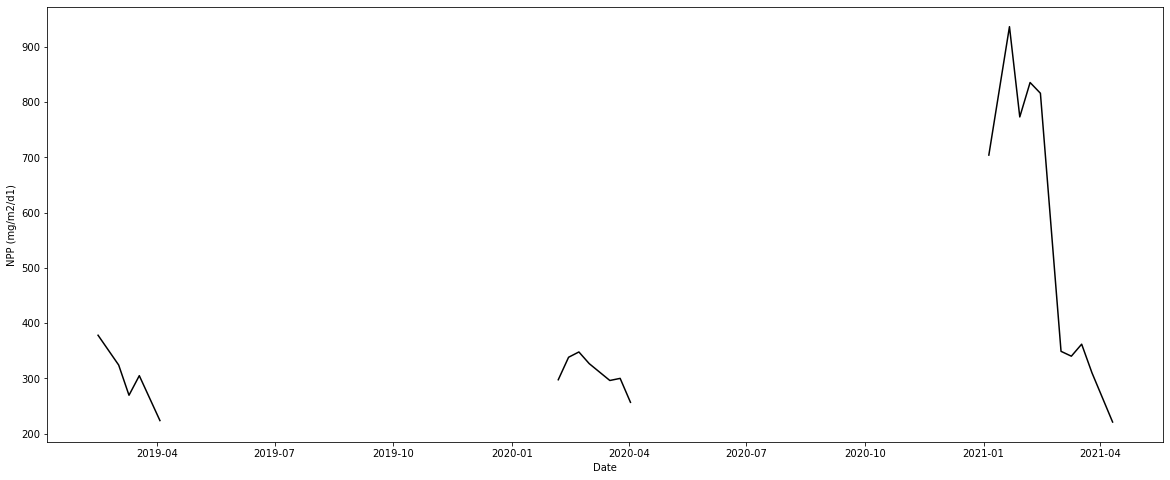

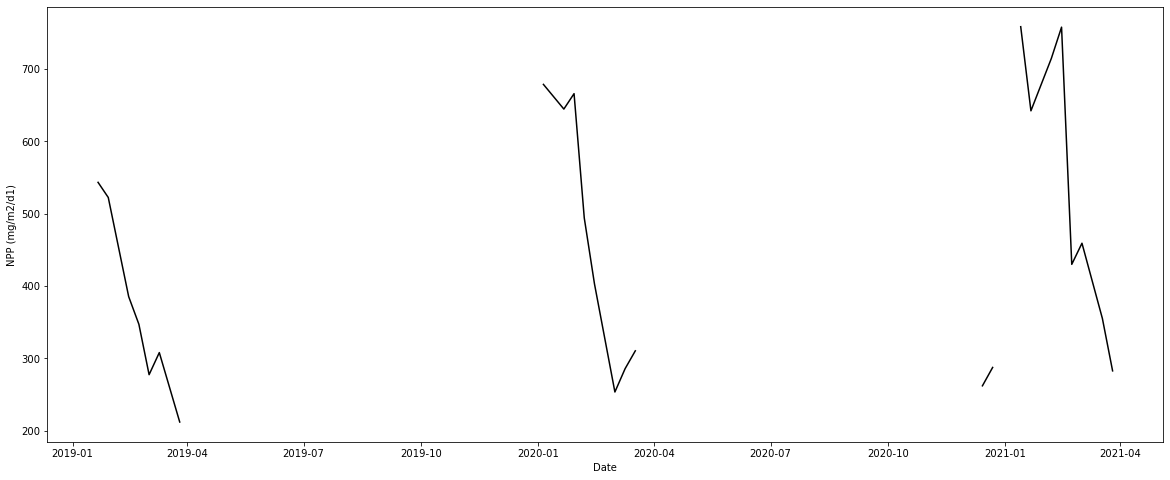

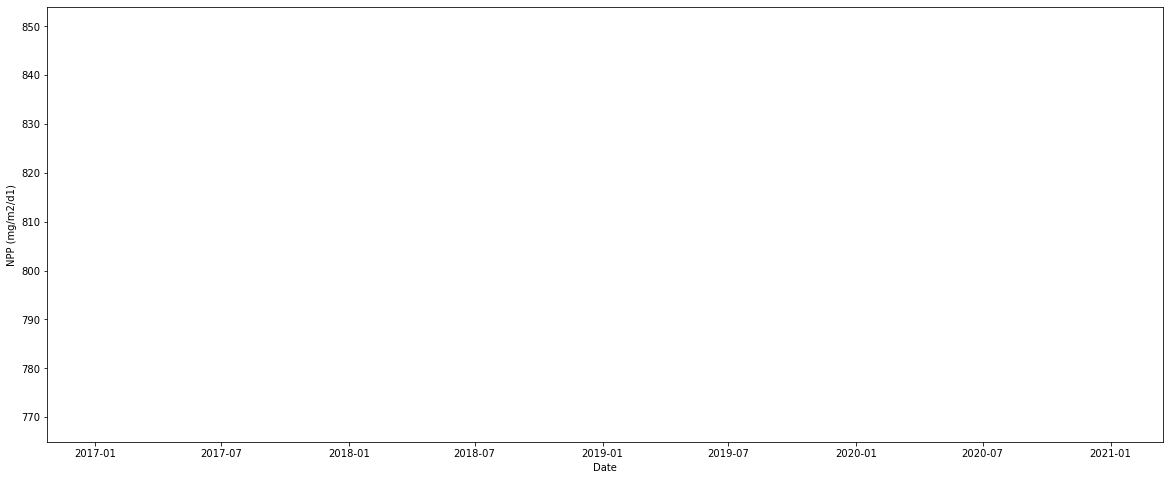

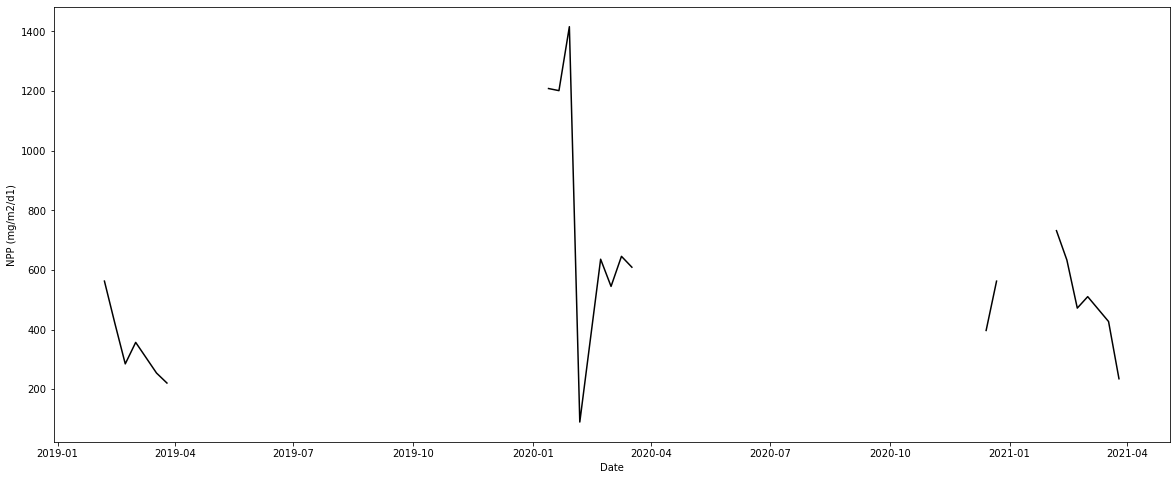

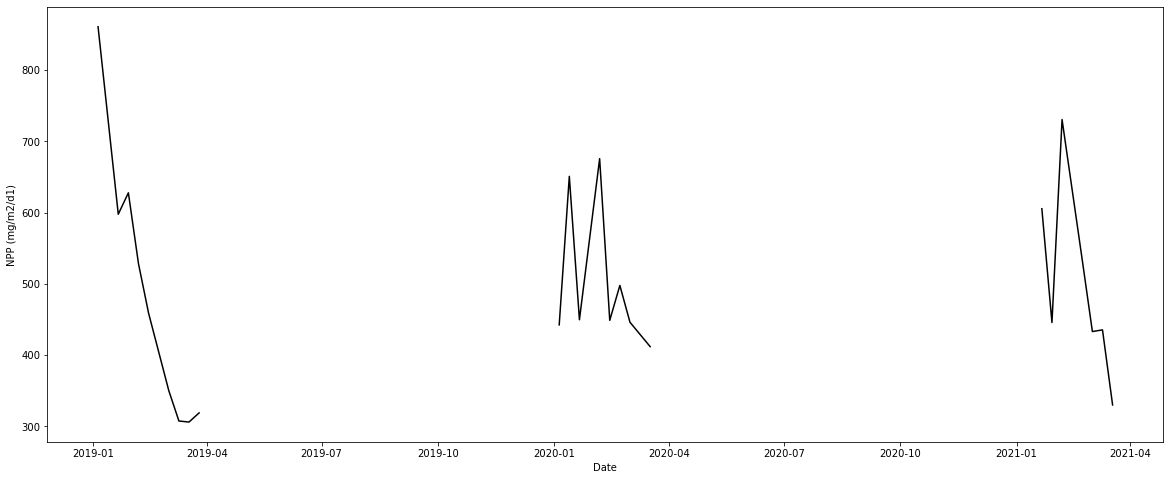

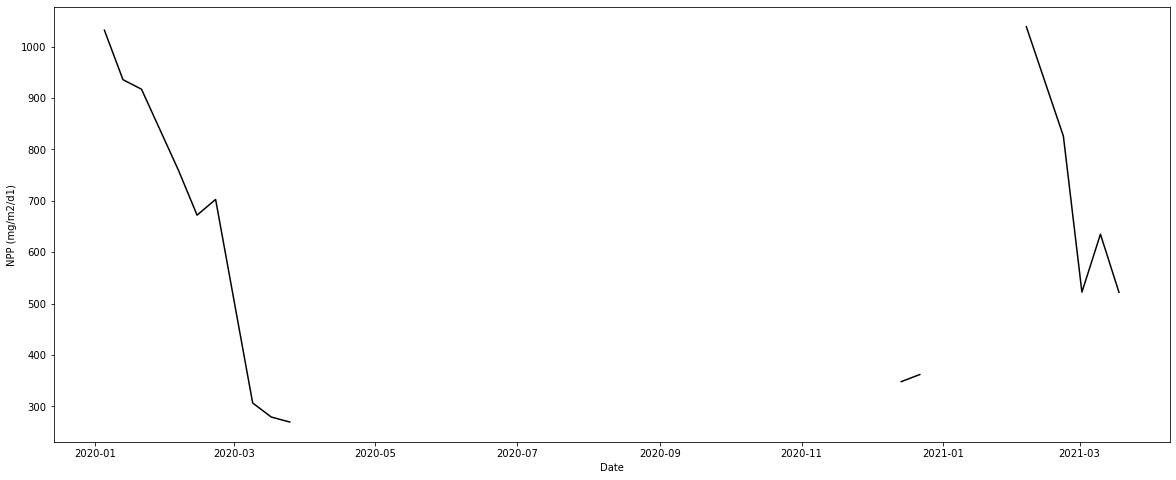

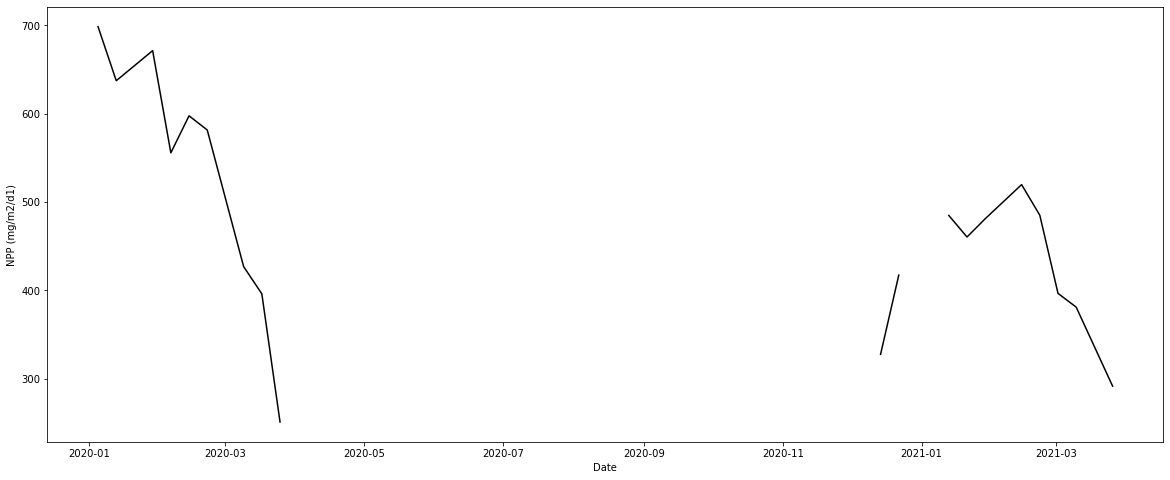

In [31]:
#make structure for floats 
AllFloats = {}

for f_ix in range(0,len(files)):
    FLOAT = grids_one_buoy(files[f_ix],display_info = False, DO_ml_crit = 2.5, clear_short = True)
    AllFloats[FLOAT.gr["WMO_code"]] = {}
    AllFloats[FLOAT.gr["WMO_code"]]['dates_dt']=FLOAT.gr["date_dt"]
    #upperlim=0
    #lowerlim=np.nanmax(FLOAT.gr["mld"])
    #print(FLOAT.gr["WMO_code"],"Deepest mixed layer: %1.0f m"%(lowerlim))
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'],AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC']=integrate_chl(FLOAT)
    
    ##### Get year range
    startyear=FLOAT.gr["date_dt"][0].year
    endyear=FLOAT.gr["date_dt"][-1].year
    #print(startyear, '-', endyear)
    
    nosat_temp=[] # getting 0/1 for no sat coverage at the end of the year for plotting later
    
    for yix in range(startyear,endyear+1,1):
        AllFloats[FLOAT.gr["WMO_code"]][yix] ={}
        AllFloats=chl_underornoice(FLOAT,yix)
        AllFloats=nosat_chl(FLOAT,yix)
        
        nosat_temp=(np.append(nosat_temp,AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]))
    
    AllFloats[FLOAT.gr["WMO_code"]]['no_sat_yesno']=np.full(len(AllFloats[FLOAT.gr["WMO_code"]]['dates_dt']), np.nan) # getting 0/1 for no sat coverage at the end of the year for plotting later
    for i in range(0,len(AllFloats[FLOAT.gr["WMO_code"]]['dates_dt'])): # getting 0/1 for no sat coverage at the end of the year for plotting later
        if (len(list(filter (lambda x : x == i, nosat_temp))) > 0):
            #print(i)
            AllFloats[FLOAT.gr["WMO_code"]]['no_sat_yesno'][i]=1
        else:
            AllFloats[FLOAT.gr["WMO_code"]]['no_sat_yesno'][i]=0
    
    ##### Get satellite values for each profile for each float
    fz=len(FLOAT.gr["date_dt"])
    ## Select satellite pixel and get NPP value
    AllFloats[FLOAT.gr["WMO_code"]]['NPP_atprofiles']=np.full(fz,np.nan)
    AllFloats[FLOAT.gr["WMO_code"]]['sat_date']=[]
    for fix in range(0,fz):
        #print(FLOAT.gr["date_dt"][fix])
        #print(FLOAT.gr["Lat"][0])
        #print(FLOAT.gr["Lon"][0])
        float_date = FLOAT.gr["date_dt"][fix]
        # get all differences with date as values 
        cloz_dict = { 
          abs(float_date.timestamp() - date.timestamp()) : date 
          for date in datezz}
        # extracting minimum key using min()
        AllFloats[FLOAT.gr["WMO_code"]]['sat_date'] = np.append(AllFloats[FLOAT.gr["WMO_code"]]['sat_date'],cloz_dict[min(cloz_dict.keys())])
        #print("Nearest date from float date : " + str(sat_date))
        #date_ix=[]
        date_ix=np.where(datezz==AllFloats[FLOAT.gr["WMO_code"]]['sat_date'][fix])
        date_sel=fd['date'][date_ix]
        
        #AllFloats[FLOAT.gr["WMO_code"]]['NPP_atprofiles'][fix]=fd['npp'].sel(date=date_sel,lat=FLOAT.gr["Lat"][0],lon=FLOAT.gr["Lon"][0],method='nearest').values
        AllFloats[FLOAT.gr["WMO_code"]]['NPP_atprofiles'][fix]=fd['npp'].sel(date=date_sel,lat=FLOAT.gr["Lat"][fix],lon=FLOAT.gr["Lon"][fix],method='nearest').values
        #AllFloats[FLOAT.gr["WMO_code"]]['NPP_atprofiles'][fix]=fd['npp'].sel(date=date_sel,lat=-50,lon=25,method='nearest').values # just choosing a randon single location to check code
    
    AllFloats[FLOAT.gr["WMO_code"]]['NPP_atprofiles'][np.where(AllFloats[FLOAT.gr["WMO_code"]]['NPP_atprofiles']<0)]=np.nan
    #display(AllFloats[FLOAT.gr["WMO_code"]]['NPP_atprofiles'])

    #Plot
    fig = plt.subplots(figsize = (20, 8))
    plt.plot(AllFloats[FLOAT.gr["WMO_code"]]['sat_date'],AllFloats[FLOAT.gr["WMO_code"]]['NPP_atprofiles'], c='black')
    plt.ylabel('NPP (mg/m2/d1)')
    plt.xlabel('Date')

5904471 Deepest mixed layer: 209 m
2014 under ice nan
2014 no satellite coverage nan
2015 under ice 0.051
2015 no satellite coverage 0.134
2016 under ice 0.056
2016 no satellite coverage 0.123
2017 under ice 0.07
2017 no satellite coverage 0.174
2018 under ice 0.051
2018 no satellite coverage 0.21
2019 under ice 0.062
2019 no satellite coverage 0.082


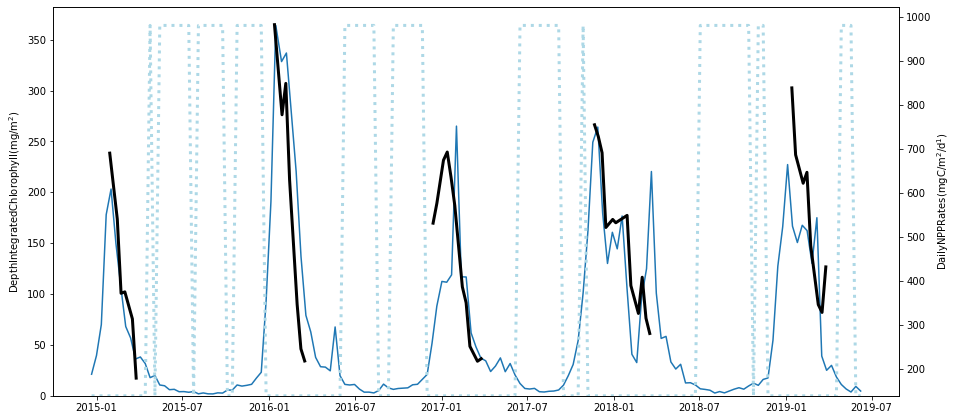

In [19]:
#chl_plot=AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200']
chl=AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200']
date=AllFloats[FLOAT.gr["WMO_code"]]['dates_dt']

fig = plt.figure(figsize = (25,20))
ax0 = fig.add_axes([0.07,0.65,0.47,0.27])
ax0.plot(date,chl)
ax0.set_ylim(0)
ax0.set_ylabel('$\mathregular {Depth Integrated Chlorophyll (mg/m^2)}$')

ax1=ax0.twinx()
ax1.plot(sat_date,NPP_atprofiles, c='black',linewidth=3)
ax1.set_ylabel('$\mathregular {Daily NPP Rates (mgC/m^2/d^1)}$')

underice4,=ax0.plot(FLOAT.gr["date_dt"],(AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno']*(np.nanmax(chl))),c='lightblue',ls=':',lw=3)
#nosat__,=ax0.plot(FLOAT.gr["date_dt"],(AllFloats[FLOAT.gr["WMO_code"]]['no_sat_yesno']*(np.nanmax(chl))),c='orange',ls=':',lw=3)

## Match-up

### Get info from a single profile

In [7]:
print(FLOAT.gr["date_dt"][0])
print(FLOAT.gr["Lat"][0])
print(FLOAT.gr["Lon"][0])


2014-12-21 12:45:59.999996
-10000000000.0
-10000000000.0


### Select satellite pixel and get NPP value

In [8]:
float_date = FLOAT.gr["date_dt"][0]
# get all differences with date as values 
cloz_dict = { 
  abs(float_date.timestamp() - date.timestamp()) : date 
  for date in datezz}
# extracting minimum key using min()
sat_date = cloz_dict[min(cloz_dict.keys())]
# printing result
print("Nearest date from float date : " + str(sat_date))

date_ix=np.where(datezz==sat_date)
date_sel=fd['date'][date_ix]

fd['npp'].sel(date=date_sel,lat=FLOAT.gr["Lat"][0],lon=FLOAT.gr["Lon"][0],method='nearest').values

Nearest date from float date : 2014-12-22 23:59:59.500003


C:\anaconda\anaconda3\envs\argo_ncp\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\anaconda\anaconda3\envs\argo_ncp\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


array([-9999.])

### Get info from profiles - all